Forme VGG/ResNet: (60000, 32, 32, 3) | Forme CAE: (60000, 784)

=== Entraînement VGG16 ===
Epoch 1/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - loss: 0.0266 - val_loss: 0.0163
Epoch 2/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0157 - val_loss: 0.0151
Epoch 3/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 4/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0134 - val_loss: 0.0139
Epoch 5/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0128 - val_loss: 0.0135
Epoch 6/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0121 - val_loss: 0.0131
Epoch 7/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0118 - val_loss: 0.0130
Epoch 8/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0114 - val_loss: 0.0126
Epoch 9/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0111 - val_loss: 0.0126
Epoch 10/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 11

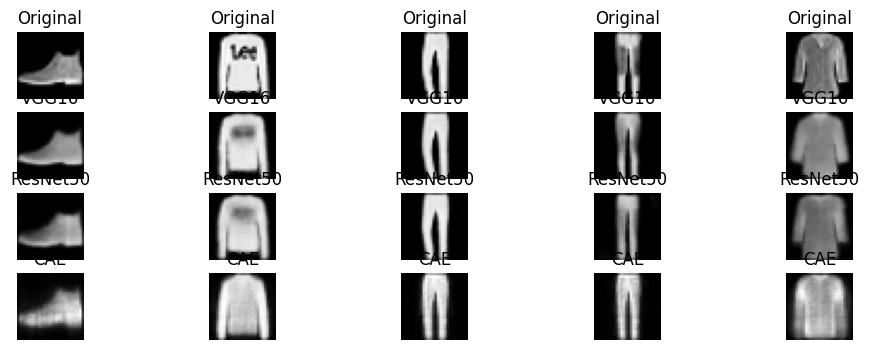

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


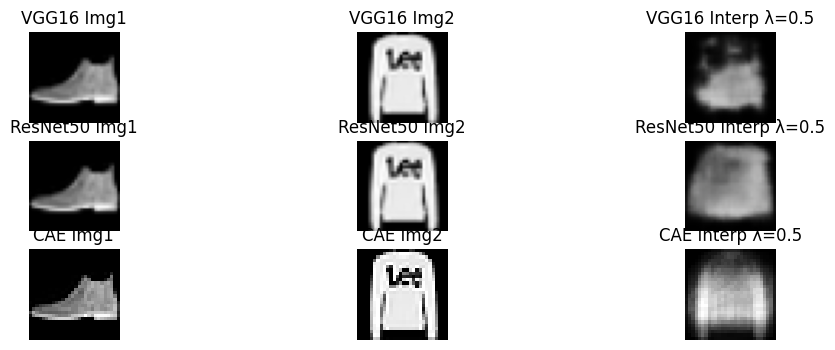

In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Reshape, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# ===========================
# 1️⃣ Préparation des données
# ===========================
(X_train, _), (X_test, _) = fashion_mnist.load_data()

# Pour VGG16 / ResNet - redimensionnement et conversion en RGB
X_train_resized = np.array([cv2.resize(img, (32,32)) for img in X_train])
X_test_resized  = np.array([cv2.resize(img, (32,32)) for img in X_test])
X_train_resized = np.expand_dims(X_train_resized, -1)
X_test_resized  = np.expand_dims(X_test_resized, -1)
X_train_rgb = np.concatenate([X_train_resized]*3, axis=-1)
X_test_rgb  = np.concatenate([X_test_resized]*3, axis=-1)
X_train_rgb = X_train_rgb.astype("float32")/255.
X_test_rgb  = X_test_rgb.astype("float32")/255.

# Pour contractive autoencoder - format plat pour MLP
X_train_scaled = X_train.astype('float32')/255.
X_test_scaled  = X_test.astype('float32')/255.
X_train_scaled = X_train_scaled.reshape(-1,28*28)
X_test_scaled  = X_test_scaled.reshape(-1,28*28)

print("Forme VGG/ResNet:", X_train_rgb.shape, "| Forme CAE:", X_train_scaled.shape)

# ===========================
# 2️⃣ Décodeur commun pour CNN-based autoencodeurs
# ===========================
def build_decoder(latent_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4*4*128, activation='relu')(decoder_input)
    x = Reshape((4,4,128))(x)


    for filters in [128,64,32]:
        x = Conv2DTranspose(filters, (3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Dernière couche pour reconstruire l'image 32x32x3
    decoded = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(decoder_input, decoded)
    return decoder

# ===========================
# 3️⃣ Fonction autoencoder VGG/ResNet
# ===========================
def build_autoencoder(base_model_class, name):
    # Chargement du modèle pré-entraîné (VGG16 ou ResNet50)
    base_model = base_model_class(input_shape=(32,32,3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Gel des poids pour le transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Réduction dimensionnelle
    encoder = Model(base_model.input, x, name=f"{name}_encoder")

    latent_dim = encoder.output_shape[-1]  # Dimension de l'espace latent
    decoder = build_decoder(latent_dim)  # Décodeur partagé

    # Construction de l'autoencodeur complet
    input_img = Input(shape=(32,32,3))
    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = Model(input_img, decoded, name=f"{name}_autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

# ===========================
# 4️⃣ Contractive Autoencoder - VERSION CORRIGÉE
# ===========================
input_dim = 28*28
latent_dim_cae = 64
lambda_c = 1e-3

# Construction séparée de l'encodeur pour la loss contractive
input_img_cae = Input(shape=(input_dim,))
encoded_cae = Dense(128, activation='relu')(input_img_cae)
encoded_cae = Dense(latent_dim_cae, activation='relu', name='latent_layer')(encoded_cae)

decoded_cae = Dense(128, activation='relu')(encoded_cae)
decoded_cae = Dense(input_dim, activation='sigmoid')(decoded_cae)

autoencoder_cae = Model(input_img_cae, decoded_cae)

# Loss contractive CORRIGÉE
def contractive_loss(y_true, y_pred):
    # MSE reconstruction
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Régularisation contractive - APPROCHE CORRIGÉE
    # On crée un modèle séparé pour l'encodeur
    encoder_model = Model(input_img_cae, encoded_cae)

    # Calcul du jacobien sur un batch
    with tf.GradientTape(persistent=True) as tape:
        # On utilise tf.identity pour convertir KerasTensor en Tensor
        input_tensor = tf.identity(input_img_cae)
        tape.watch(input_tensor)
        latent_code = encoder_model(input_tensor)

    # Calcul du jacobien
    jacobian = tape.batch_jacobian(latent_code, input_tensor)
    frob_norm = tf.reduce_mean(tf.square(jacobian))

    return mse_loss + lambda_c * frob_norm

# Alternative PLUS SIMPLE si la version ci-dessus pose problème :
def contractive_loss_simple(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Pénalité sur les poids de l'encodeur (approximation)
    w_penalty = 0
    for layer in autoencoder_cae.layers:
        if 'dense' in layer.name and 'latent_layer' not in layer.name:
            if layer.weights:
                w_penalty += tf.reduce_sum(tf.square(layer.weights[0]))

    return mse_loss + lambda_c * w_penalty

# Utiliser la version simple pour éviter les problèmes
autoencoder_cae.compile(optimizer='adam', loss=contractive_loss_simple)
# ===========================
# 5️⃣ Entraînement des modèles
# ===========================
results = {}

# Entraînement des autoencodeurs basés sur VGG16 et ResNet50
for model_class, name in [(VGG16,"VGG16"), (ResNet50,"ResNet50")]:
    print(f"\n=== Entraînement {name} ===")
    autoencoder, encoder, decoder = build_autoencoder(model_class, name)
    callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]
    autoencoder.fit(X_train_rgb, X_train_rgb, validation_split=0.1,
                    epochs=25, batch_size=32, callbacks=callbacks, verbose=1)
    mse = autoencoder.evaluate(X_test_rgb, X_test_rgb, verbose=0)
    results[name] = {"autoencoder": autoencoder, "encoder": encoder, "decoder": decoder, "mse": mse}

# Entraînement du Contractive Autoencoder
print("\n=== Entraînement Contractive Autoencoder ===")
callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]
autoencoder_cae.fit(X_train_scaled, X_train_scaled, validation_split=0.1,
                    epochs=50, batch_size=128, callbacks=callbacks, verbose=1)
mse_cae = autoencoder_cae.evaluate(X_test_scaled, X_test_scaled, verbose=0)
results["CAE"] = {"autoencoder": autoencoder_cae, "encoder": Model(input_img_cae, encoded_cae),
                  "decoder": Model(encoded_cae, decoded_cae), "mse": mse_cae}

# ===========================
# 6️⃣ Affichage MSE
# ===========================
print("\n=== MSE Comparatif ===")
for name in results:
    print(f"{name} : {results[name]['mse']:.6f}")

# ===========================
# 7️⃣ Reconstructions
# ===========================
plt.figure(figsize=(12,4))
n = 5
for i in range(n):
    # Original
    plt.subplot(4,n,i+1); plt.imshow(X_test_rgb[i]); plt.title("Original"); plt.axis('off')

    # Reconstruction VGG16
    plt.subplot(4,n,i+1+n);
    decoded = results["VGG16"]["autoencoder"].predict(X_test_rgb[i:i+1])
    plt.imshow(decoded[0]); plt.title("VGG16"); plt.axis('off')

    # Reconstruction ResNet50
    plt.subplot(4,n,i+1+2*n);
    decoded = results["ResNet50"]["autoencoder"].predict(X_test_rgb[i:i+1])
    plt.imshow(decoded[0]); plt.title("ResNet50"); plt.axis('off')

    # Reconstruction CAE
    plt.subplot(4,n,i+1+3*n);
    decoded = results["CAE"]["autoencoder"].predict(X_test_scaled[i:i+1])
    plt.imshow(decoded[0].reshape(28,28), cmap='gray'); plt.title("CAE"); plt.axis('off')
plt.show()

# ===========================
# 8️⃣ Interpolation linéaire
# ===========================
img_idx1, img_idx2 = 0, 1
lambda_val = 0.5  # Paramètre d'interpolation

plt.figure(figsize=(12,4))
for j, name in enumerate(["VGG16","ResNet50","CAE"]):
    encoder = results[name]["encoder"]
    decoder = results[name]["decoder"]

    # Encodage des deux images
    if name == "CAE":
        # Pour CAE, utilisation des données scalées
        latent1 = encoder.predict(X_test_scaled[img_idx1:img_idx1+1])
        latent2 = encoder.predict(X_test_scaled[img_idx2:img_idx2+1])
    else:
        # Pour VGG/ResNet, utilisation des données RGB
        latent1 = encoder.predict(X_test_rgb[img_idx1:img_idx1+1])
        latent2 = encoder.predict(X_test_rgb[img_idx2:img_idx2+1])


    latent_interp = (1 - lambda_val) * latent1 + lambda_val * latent2
    img_interp = decoder.predict(latent_interp)

    # Affichage des résultats
    if name == "CAE":
        plt.subplot(3,3,j*3+1); plt.imshow(X_test_scaled[img_idx1].reshape(28,28), cmap='gray'); plt.title(f"{name} Img1"); plt.axis('off')
        plt.subplot(3,3,j*3+2); plt.imshow(X_test_scaled[img_idx2].reshape(28,28), cmap='gray'); plt.title(f"{name} Img2"); plt.axis('off')
        plt.subplot(3,3,j*3+3); plt.imshow(img_interp[0].reshape(28,28), cmap='gray'); plt.title(f"{name} Interp λ={lambda_val}"); plt.axis('off')
    else:
        plt.subplot(3,3,j*3+1); plt.imshow(X_test_rgb[img_idx1]); plt.title(f"{name} Img1"); plt.axis('off')
        plt.subplot(3,3,j*3+2); plt.imshow(X_test_rgb[img_idx2]); plt.title(f"{name} Img2"); plt.axis('off')
        plt.subplot(3,3,j*3+3); plt.imshow(img_interp[0]); plt.title(f"{name} Interp λ={lambda_val}"); plt.axis('off')
plt.show()